  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2931166/783472909.py:79: RuntimeWarning: invalid value encountered in true_divide
  A_new = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0)[:, np.newaxis]
100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


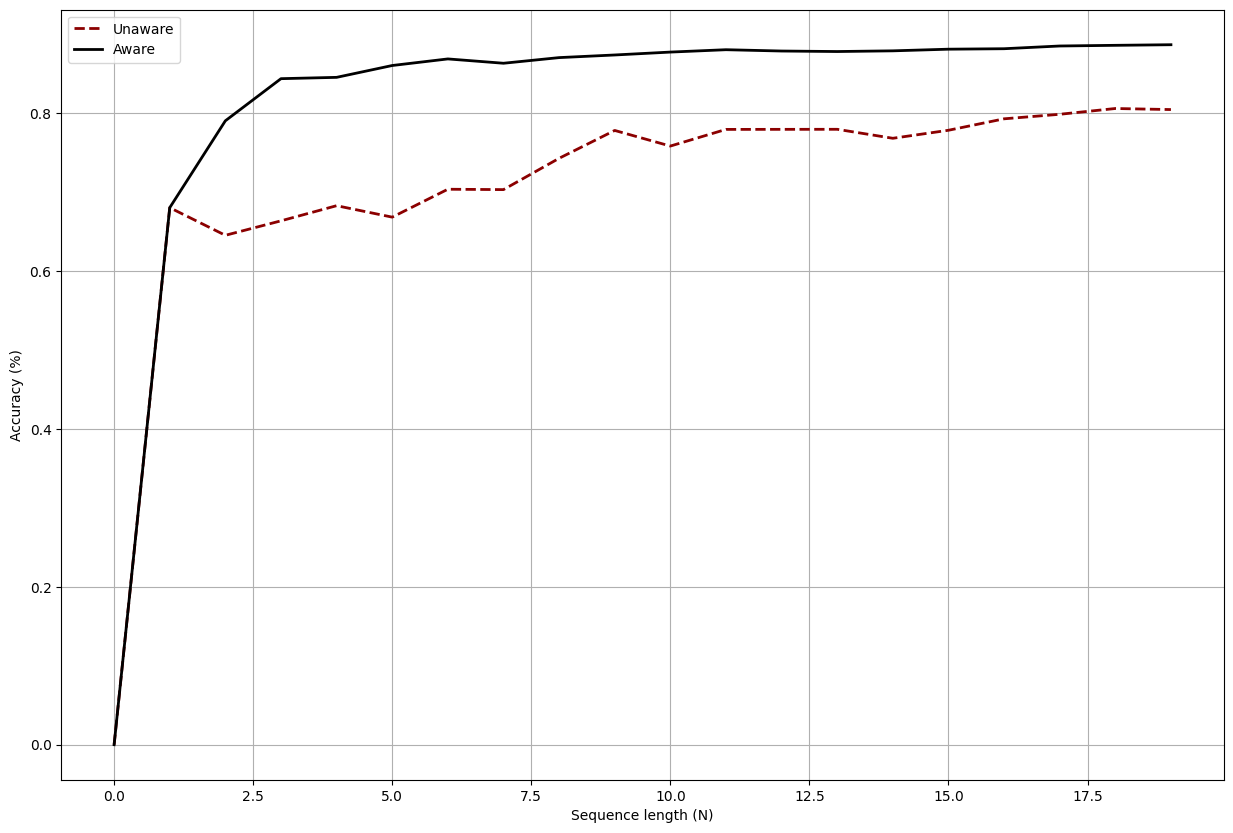

In [1]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt


# Vectorized forward algorithm with scaling
def forward_algorithm(y, A, p_BSC, pi):
    N = len(y)
    K = len(pi)

    channel_emission = np.array([[1-p_BSC, p_BSC], [p_BSC, 1-p_BSC]])
    
    E = channel_emission[:, y].T  # Emission probabilities

    alpha = np.zeros((N, K))
    c = np.zeros(N)
    
    # Initialization
    alpha[0, :] = E[0, :] * pi
    c[0] = np.sum(alpha[0, :])
    alpha[0, :] /= c[0]
    
    # Recursion (vectorized)
    for t in range(1, N):
        alpha[t, :] = E[t, :] * np.dot(alpha[t-1, :], A)
        c[t] = np.sum(alpha[t, :])
        alpha[t, :] /= c[t]
    
    return alpha, c, E

# Vectorized backward algorithm with scaling
def backward_algorithm(y, A, c, p_BSC):
    N = len(y)
    K = A.shape[0]
    channel_emission = np.array([[1-p_BSC, p_BSC], [p_BSC, 1-p_BSC]])
    E = channel_emission[:, y].T  # Emission probabilities  # Emission probabilities  # Emission probabilities
    beta = np.zeros((N, K))
    
    # Initialization
    beta[N-1, :] = 1.0
    
    # Recursion (vectorized)
    for t in range(N-2, -1, -1):
        beta[t, :] = np.dot(A, (E[t+1, :] * beta[t+1, :]))
        beta[t, :] /= c[t+1]
    
    return beta

# Vectorized computation of gamma and xi
def compute_gamma_xi(alpha, beta, A, B):
    N, K = alpha.shape
    gamma = alpha * beta
    
    xi = np.zeros((N-1, K, K))
    for t in range(N-1):
        xi[t, :, :] = np.outer(alpha[t, :], beta[t+1, :] * B[t+1, :]) * A
        xi[t, :, :] /= np.sum(xi[t, :, :])  # Normalize
    
    return gamma, xi

# Vectorized parameter update
def update_parameters(y, gamma, xi):
    N, K = gamma.shape
    
    # Update transition matrix A
    A_new = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0)[:, np.newaxis]
    
    return A_new

# Vectorized Baum-Welch algorithm
def baum_welch(y, K, p0_init, p1_init, p_BSC, max_iter=500, tol=1e-4):
    N = len(y)
    
    # Initialize parameters randomly
    A = np.ones((K, K)) / K
   
    # Initialize parameters exactly
    A = np.array([[p0_init, 1-p0_init],
                   [1-p1_init, p1_init]])
    
    pi = np.array([0.5, 0.5])
    
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # print('iter = ', iteration+1)
        # E-step: Compute forward, backward, gamma, and xi
        alpha, c, B = forward_algorithm(y, A, p_BSC=p_BSC, pi=pi)
        beta = backward_algorithm(y, A, p_BSC=p_BSC, c=c)
        gamma, xi = compute_gamma_xi(alpha, beta, A, B)
        
        # M-step: Update parameters
        A_new = update_parameters(y, gamma, xi)
        
        # Log-likelihood calculation
        log_likelihood = -np.sum(np.log(c))
        log_likelihoods.append(log_likelihood)
        
        # Check for convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            # print('iteration = ', iteration+1)
            break
        
        # Update parameters
        A = A_new
    
    return A, gamma, log_likelihoods


# Function to generate the hidden states and observations
def generate_data(N, A, p_BSC, pi):
    x = np.zeros(N, dtype=int)
    y = np.zeros(N)
    x[0] = np.random.choice(K, p=pi)
    y[0] = x[0] if np.random.rand() >= p_BSC else (1-x[0])
    for t in range(1, N):
        x[t] = np.random.choice(K, p=A[x[t-1], :])
        y[t] = x[t] if np.random.rand() >= p_BSC else (1-x[t])
    y = y.astype(np.uint)
    return x, y


def compute_gamma_for_true_model(y, p0_true, p1_true, p_BSC, pi, K=2):

    A_true = np.array([[p0_true, 1-p0_true], [1-p1_true, p1_true]])

    alpha, c, B = forward_algorithm(y, A_true, p_BSC=p_BSC, pi=pi)
    beta = backward_algorithm(y, A=A_true, p_BSC=p_BSC, c=c)
    gamma_est, xi = compute_gamma_xi(alpha, beta, A_true, B)

    return gamma_est


# Parameters
N = 20  # Length of the sequence
K = 2  # Number of hidden states

n_classes = 2


# a code with binary Markov chain with p1, p2 transitions
p0_true, p1_true = 0.9, 0.1
p_BSC = 0.3

accuracy = np.zeros((n_classes, N))

# True transition probability matrix
A_true = np.array([[p0_true, 1-p0_true],
                    [1-p1_true, p1_true]])

# True initial state distribution
pi_true = np.array([0.5, 0.5])

# Generate the sequences
# np.random.seed(42)  # For reproducibility

accuracy = np.zeros(N)
accuracy_model_aware = np.zeros(N)
n_samples = 100

for b in tqdm(range(n_samples)):
    x_seq, y_seq = generate_data(N, A_true, p_BSC, pi_true)

    for n in range(1,N):

        # Run the Baum-Welch algorithm
        A_est, gamma_est, log_likelihoods = baum_welch(y_seq[:n], K, p0_init=0.5, p1_init=0.5, p_BSC=p_BSC)

        # print('gamma_est sum = ', np.sum(gamma_est, axis=1))


        # Compute the gamma using the true parameters of the HMM
        gamma_est_true_model = compute_gamma_for_true_model(y=y_seq[:n], p0_true=p0_true, p1_true=p1_true, p_BSC=p_BSC, pi=pi_true, K=K)

        # Estimated state sequence
        x_hat = np.argmax(gamma_est, axis=1)
        x_hat_true_model = np.argmax(gamma_est_true_model, axis=1)

        # print('gamma_sum = ', np.sum(gamma_est_true_model, axis=1))

        # Compare the estimated states with the true states
        accuracy[n] += np.sum(x_hat == x_seq[:n]) / n
        accuracy_model_aware[n] += np.sum(x_hat_true_model == x_seq[:n]) / n

accuracy /= n_samples
accuracy_model_aware /= n_samples

plt.figure(figsize=(15, 10))
plt.plot(accuracy, label='Unaware', color='darkred', ls='dashed', lw=2)
plt.plot(accuracy_model_aware, label='Aware', color='black', lw=2)
plt.grid()
plt.xlabel('Sequence length (N)')
plt.ylabel('Accuracy (%)')
plt.legend()
# plt.savefig(f'plots/perf-unaware-vs-aware-N-{N}.png', dpi=400, bbox_inches='tight')


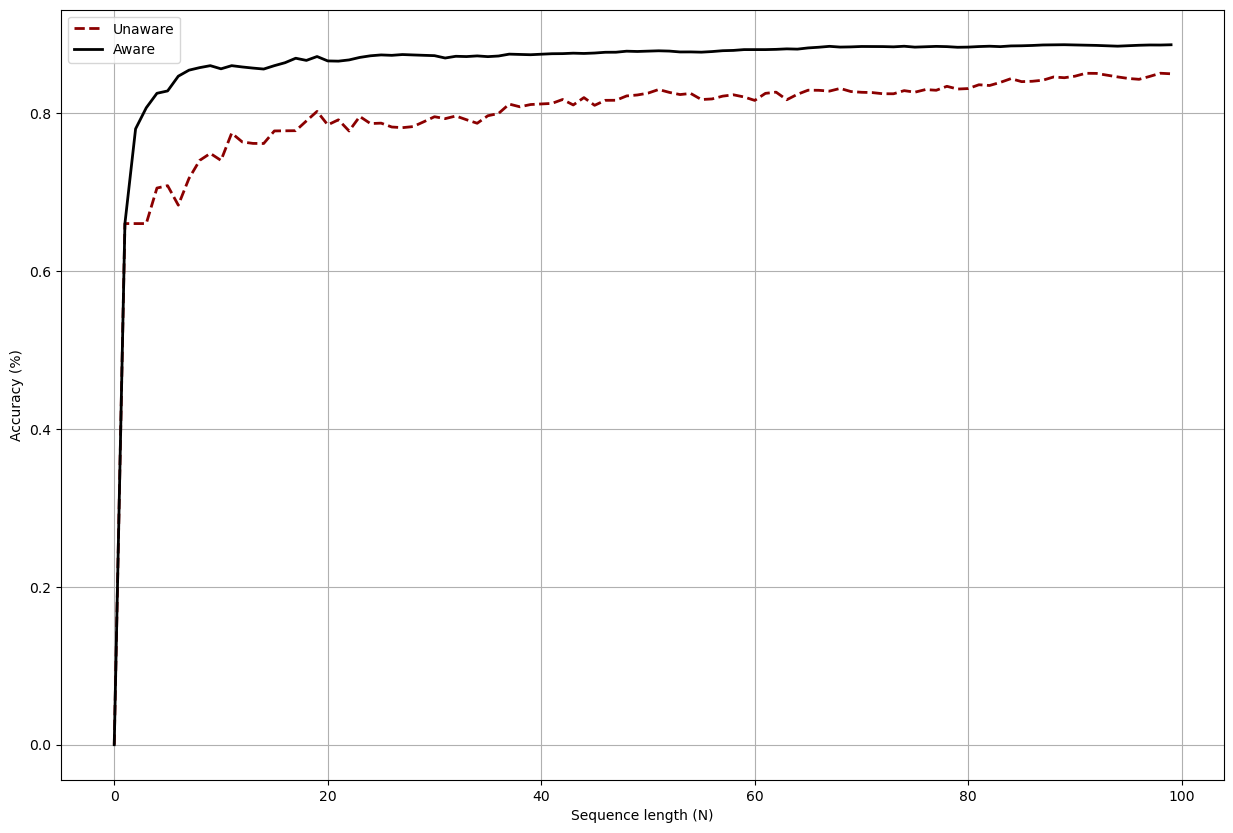

In [49]:
plt.figure(figsize=(15, 10))
plt.plot(accuracy, label='Unaware', color='darkred', ls='dashed', lw=2)
plt.plot(accuracy_model_aware, label='Aware', color='black', lw=2)
plt.grid()
plt.xlabel('Sequence length (N)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('plots/perf-unaware-vs-aware.png', dpi=400, bbox_inches='tight')


In [ ]:
# Generate plot using BSC channel and Baum-Welch algorithm


# Parameters
N = 100  # Length of the sequence
K = 2  # Number of hidden states

# a code with binary Markov chain with p0, p1 transitions
# p0, p1 = 0.2, 0.3
# p_BSC = 0.6

res = 0.1
p0_grid = np.arange(res, 1, res)
p1_grid = np.arange(res, 1, res)
p_BSC_grid = np.arange(res, 0.5+res, res)

accuracy = np.zeros((len(p_BSC_grid), len(p0_grid), len(p0_grid)))

for iB, p_BSC in tqdm(enumerate(p_BSC_grid)):
    for i0, p0 in tqdm(enumerate(p0_grid)):
        for i1, p1 in tqdm(enumerate(p1_grid)):

            # True transition probability matrix
            A_true = np.array([[p0, 1-p0],
                               [1-p1, p1]])

            # True initial state distribution
            pi_true = np.array([0.5, 0.5])

            # Generate the sequences
            # np.random.seed(42)  # For reproducibility

            accuracy[iB, i0, i1] = 0
            n_samples = 100

            for b in tqdm(range(n_samples)):
                x_seq, y_seq = generate_data(N, A_true, p_BSC, pi_true)

                # Run the Baum-Welch algorithm
                A_est, gamma_est, log_likelihoods = baum_welch(y_seq, K, p1_init=0.5, p2_init=0.5, p_BSC=p_BSC)

                # Estimated state sequence
                x_hat = np.argmax(gamma_est, axis=1)

                # print(f"Estimated States: {x_hat}")
                # print(f"True States:      {x_seq}")

                # Compare the estimated states with the true states
                accuracy[iB, i0, i1] += np.sum(x_hat == x_seq) / N
            accuracy[iB, i0, i1] /= n_samples
            print(f"Accuracy for p_BSC = {p_BSC}, p0 = {p0}, p1 = {p1}: {accuracy[iB, i0, i1] * 100:.2f}%")

np.save('files/accuracy1.npy', accuracy)

5it [00:03,  1.40it/s]


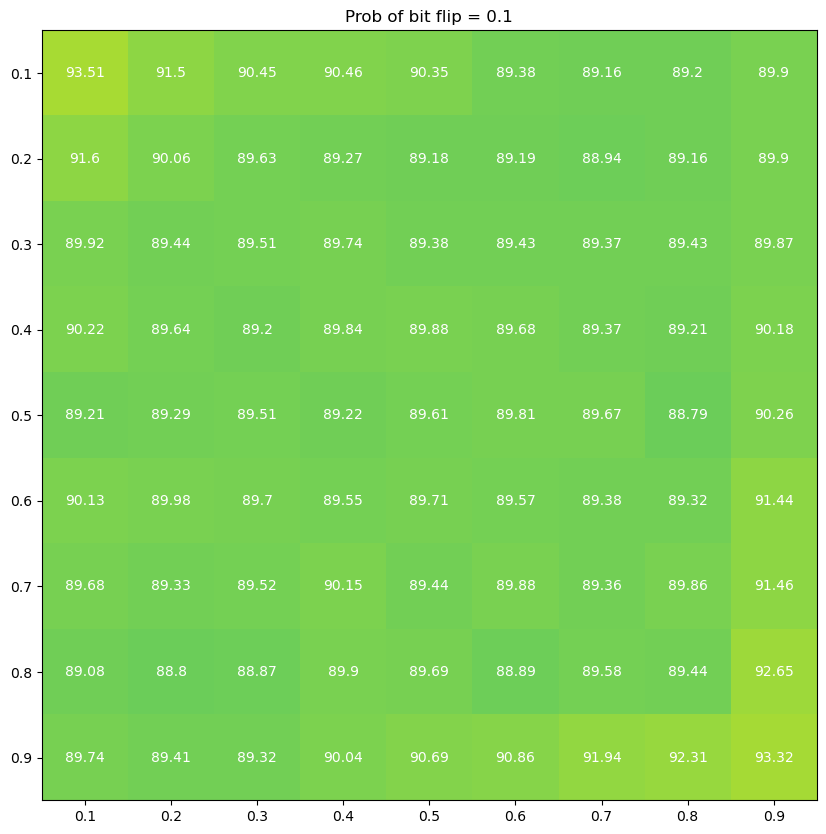

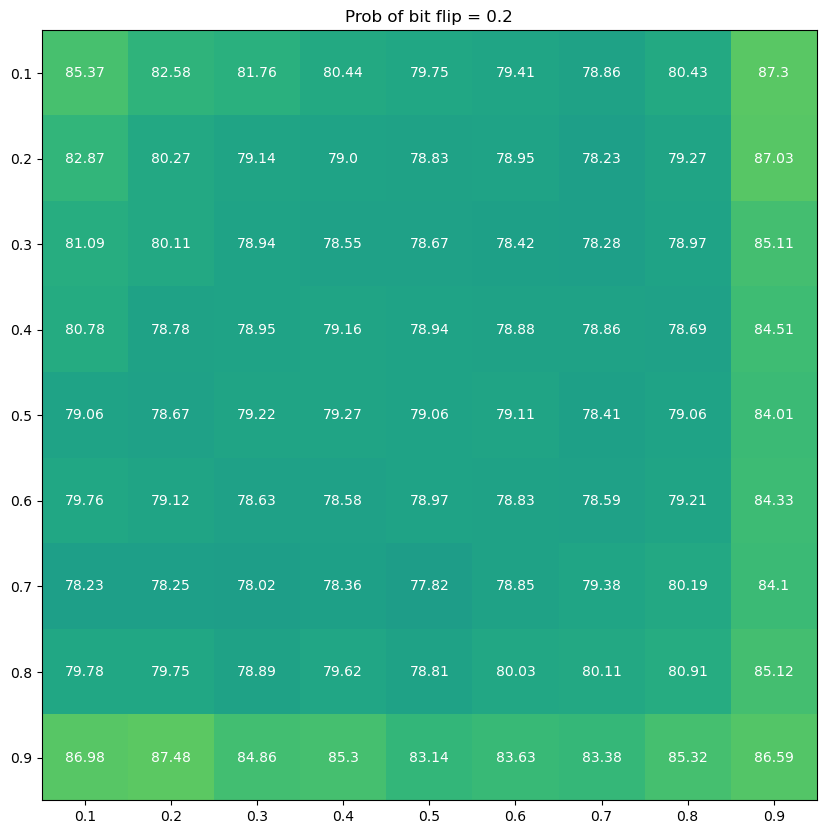

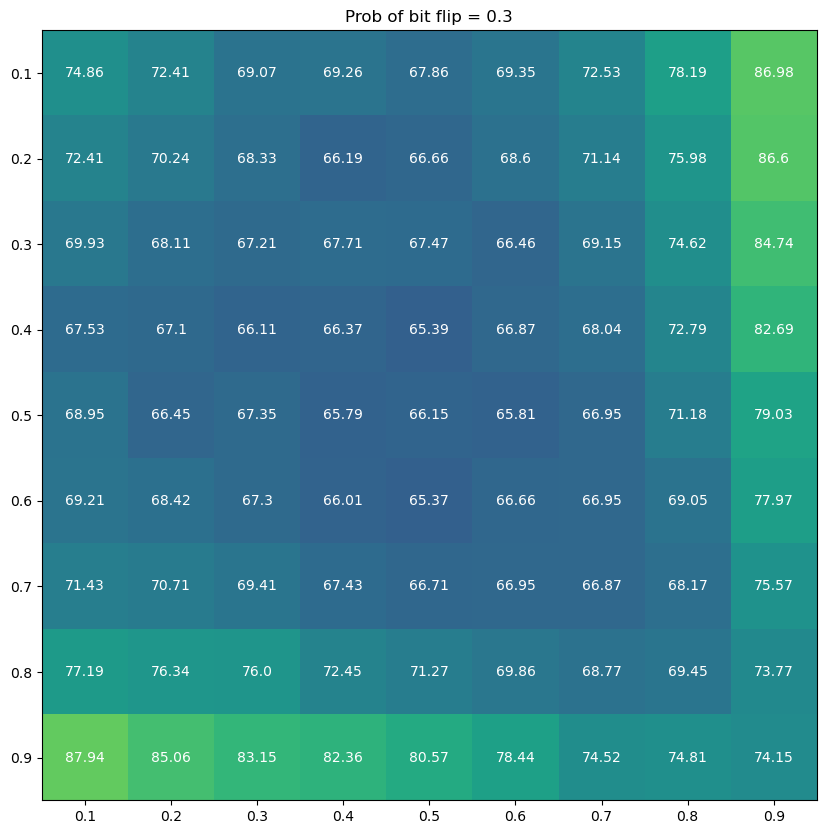

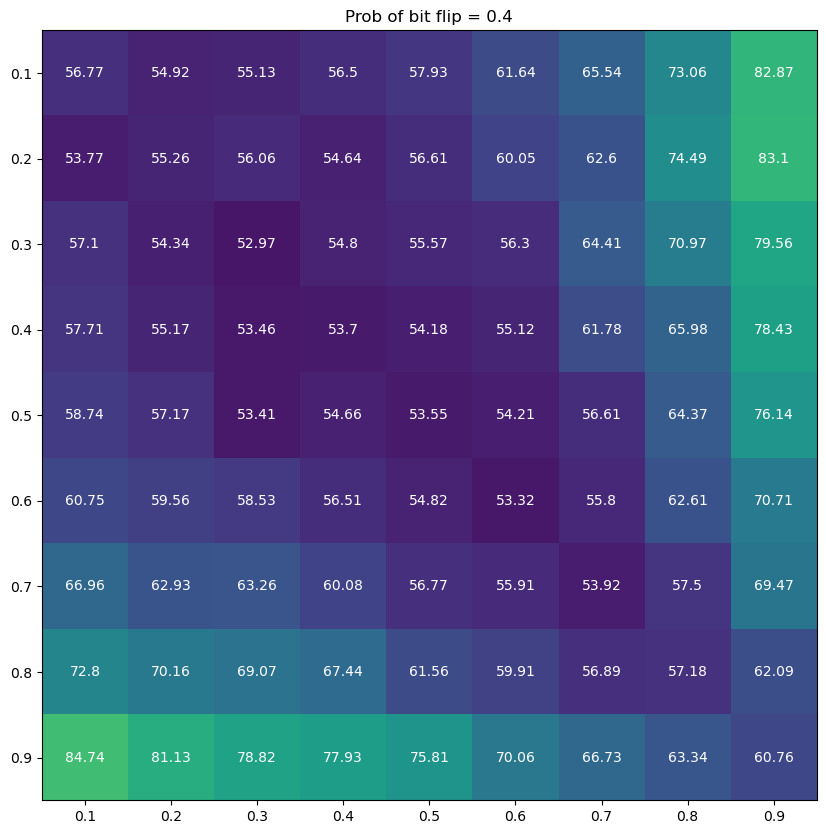

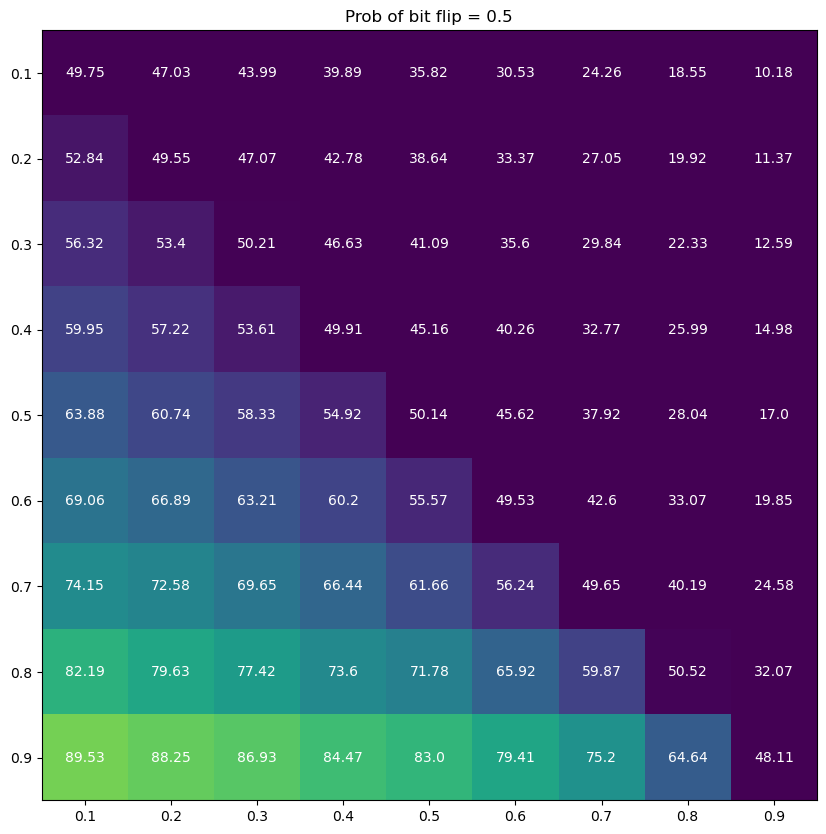

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

p1_grid = np.round(np.arange(res, 1, res), decimals=1)
p2_grid = np.round(np.arange(res, 1, res), decimals=1)
p_BSC_grid = np.round(np.arange(res, 0.5+res, res), decimals=1)


accuracy = np.load('accuracy.npy')

acc_round = np.round(accuracy*100, decimals=2)

for iB, p_BSC in tqdm(enumerate(p_BSC_grid)):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.imshow(accuracy[iB, :, :], aspect='auto', vmin=0.5, vmax=1)
    ax.set_yticks(np.arange(len(p1_grid)), labels=p1_grid)
    ax.set_xticks(np.arange(len(p2_grid)), labels=p2_grid)
    ax.set_title(f'Prob of bit flip = {np.round(p_BSC, decimals=1)}')

    for i in range(len(p1_grid)):
        for j in range(len(p2_grid)):
            text = ax.text(i, j, acc_round[iB,j,i],
                        ha="center", va="center", color="w")
            
    plt.savefig(f'plots/BW-p_BSC-{p_BSC}.png', bbox_inches='tight', dpi=300)
        
    


